### HW4, Jordan Gittleman

In [148]:
import os
import cv2
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from collections import namedtuple
import math
import gtsam
import gtsam.utils.plot
import itertools




In [149]:
siftPts = namedtuple('siftPts', 'k d')
def siftDC(img):
    img=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    # take in source and destinatition photos and outputs sift detected key points and computed descriptors as an array
    sift = cv2.SIFT_create(nfeatures=4000,
                                   nOctaveLayers=6,
                                   contrastThreshold=0.025,
                                   sigma=1.5) #create our detector
    keypoints, descriptors = sift.detectAndCompute(img,None) # detect keypoints and compute descriptors

    return siftPts(keypoints,descriptors)

In [150]:
def matchMaker(d1,d2,pts):
    # takes in keypoints and descriptors for two images and returns a sorted index of matches using bfmatcher
    # bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # matches = bf.match(d1,d2)
    # matches = sorted(matches, key = lambda x:x.distance)

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(d1,d2, k=2)

    # Apply ratio test
    good = []
    goodmatch = 0
    ratio = 0.01
    while goodmatch <= pts:
        for m in matches:
            if m[0].distance < ratio*m[1].distance :
                good.append(m[0])
                goodmatch +=1
        ratio += .05

    good = sorted(good, key = lambda x:x.distance)

    return matches, good

In [151]:

def getFun(dest_kp, src_kp,good): # find fundamental matrix, works in much the same way as finding H

    dest = np.array([dest_kp[mat.queryIdx].pt for mat in good])
    src = np.array([src_kp[mat.trainIdx].pt for mat in good]) 

    F, mask = cv2.findFundamentalMat(dest,src,cv2.FM_RANSAC)
    return F, mask, src, dest

 


In [152]:
# Lets start by making a function to load in our images and detect features, storing what we find for later
Graphbin = namedtuple('Graphbin', 'im pts')
def gtloader(folder):
    im_paths = []
    for file in os.listdir(folder):
        if ".png" in file:
            im_paths.append(os.path.join(folder,file))
            # print(im_paths)

    # now lets find features for each image and put them in a list
    imgsAndPts=[]
    im_paths.sort()
    for image in im_paths:
        img = cv2.imread(image)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (0,0), fx=1, fy=1)
        imgsAndPts.append(Graphbin(img,siftDC(img)))

    im_height, im_width = img.shape[:2]
    # get center point of image, this is our "pose"
    cam_matrix = np.array([[1, 0, im_width/2], 
                          [0, 1, im_height/2],
                          [0, 0, 1]])

    return imgsAndPts, cam_matrix

In [153]:
buddha,cam_matrix=gtloader("./buddha_images")


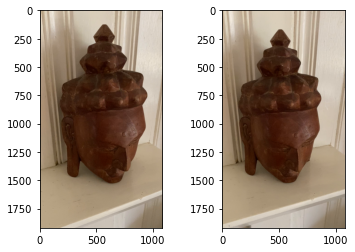

In [154]:
plt.subplot(121), plt.imshow(buddha[4].im)
plt.subplot(122), plt.imshow(buddha[5].im)
plt.show()

In [155]:
matches, good = matchMaker(buddha[1].pts.d,buddha[2].pts.d,500)
imgLeft = buddha[1].im
imgRight = buddha[2].im

F, mask, ptsLeft, ptsRight= getFun(buddha[1].pts.k,buddha[2].pts.k,good)
print(F)
ptsLeft = np.int32(ptsLeft)
ptsRight = np.int32(ptsRight)
# We select only inlier points
ptsLeft = ptsLeft[mask.ravel() == 1]
ptsRight = ptsRight[mask.ravel() == 1]

[[ 5.98276015e-08  2.68661193e-06 -2.21655678e-03]
 [-3.51272684e-06  4.05606224e-07  1.97980244e-02]
 [ 2.39863898e-03 -2.10856250e-02  1.00000000e+00]]


In [156]:
def drawlines(img1, img2, lines, pts1, pts2):

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
      
    for r, pt1, pt2 in zip(lines, pts1, pts2):
          
        color = tuple(np.random.randint(0, 255,
                                        3).tolist())
          
        x0, y0 = map(int, [0, -r[2] / r[1] ])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1] ])
          
        img1 = cv2.line(img1, 
                        (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1,
                          tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, 
                          tuple(pt2), 5, color, -1)
    return img1, img2

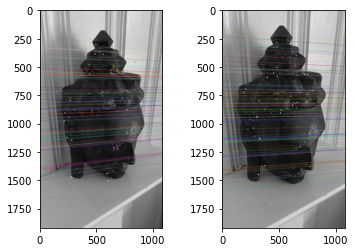

In [157]:
# Find epilines corresponding to points
# in right image (second image) and
# drawing its lines on left image
linesLeft = cv2.computeCorrespondEpilines(ptsRight.reshape(-1,
                                                           1,
                                                           2),
                                          2, F)
linesLeft = linesLeft.reshape(-1, 3)
img5, img6 = drawlines(imgLeft, imgRight, 
                       linesLeft, ptsLeft,
                       ptsRight)
   
# Find epilines corresponding to 
# points in left image (first image) and
# drawing its lines on right image
linesRight = cv2.computeCorrespondEpilines(ptsLeft.reshape(-1, 1, 2), 
                                           1, F)
linesRight = linesRight.reshape(-1, 3)
  
img3, img4 = drawlines(imgRight, imgLeft, 
                       linesRight, ptsRight,
                       ptsLeft)
   
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.show()

In [158]:
#steps: fund mat -> essential -> recover pose -> projection mat -> triangulate pts
essential=cam_matrix.transpose()@F@cam_matrix

essential=cv2.findEssentialMat(ptsLeft,ptsRight,cam_matrix)

In [159]:
print(essential[0])

[[ 1.89699287e-05 -8.39823945e-04 -1.47447413e-01]
 [ 8.60567655e-04  1.96786926e-05 -6.91562377e-01]
 [ 1.35278903e-01  6.94045323e-01  8.77904546e-06]]


In [160]:
pts, R, t, mask = cv2.recoverPose(essential[0], ptsLeft, ptsRight)

In [161]:
print(t)

[[ 0.97801693]
 [-0.20852212]
 [ 0.00118935]]


In [162]:
def PlotCamera(R,t,ax,scale=.5,depth=.5,faceColor='grey'):
    C = -t #camera center (in world coordinate system)

    #Generating camera coordinate axes
    axes = np.zeros((3,6))
    axes[0,1], axes[1,3],axes[2,5] = 1,1,1
    
    #Transforming to world coordinate system 
    axes = R.T.dot(axes)+C[:,np.newaxis]

    #Plotting axes
    ax.plot3D(xs=axes[0,:2],ys=axes[1,:2],zs=axes[2,:2],c='r')
    ax.plot3D(xs=axes[0,2:4],ys=axes[1,2:4],zs=axes[2,2:4],c='g')
    ax.plot3D(xs=axes[0,4:],ys=axes[1,4:],zs=axes[2,4:],c='b')

    #generating 5 corners of camera polygon 
    pt1 = np.array([[0,0,0]]).T #camera centre
    pt2 = np.array([[scale,-scale,depth]]).T #upper right 
    pt3 = np.array([[scale,scale,depth]]).T #lower right 
    pt4 = np.array([[-scale,-scale,depth]]).T #upper left
    pt5 = np.array([[-scale,scale,depth]]).T #lower left
    pts = np.concatenate((pt1,pt2,pt3,pt4,pt5),axis=-1)
    
    #Transforming to world-coordinate system
    pts = R.T.dot(pts)+C[:,np.newaxis]
    ax.scatter3D(xs=pts[0,:],ys=pts[1,:],zs=pts[2,:],c='k')
    
    #Generating a list of vertices to be connected in polygon
    verts = [[pts[:,0],pts[:,1],pts[:,2]], [pts[:,0],pts[:,2],pts[:,-1]],
            [pts[:,0],pts[:,-1],pts[:,-2]],[pts[:,0],pts[:,-2],pts[:,1]]]
    
    #Generating a polygon now..
    ax.add_collection3d(Poly3DCollection(verts, facecolors=faceColor,
                                         linewidths=1, edgecolors='k', alpha=.25))

[0 0 0]


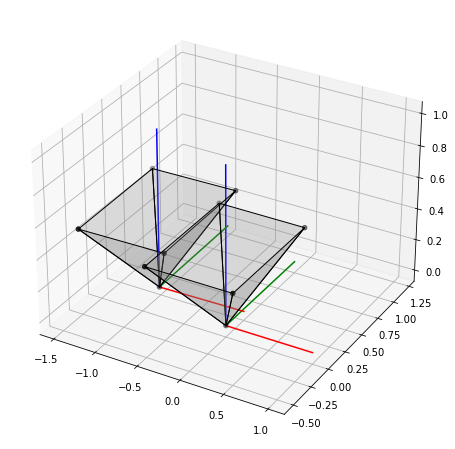

In [163]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')
#for initial camera
R1=np.eye(3)
t1=np.array([0,0,0])
print(t1)
PlotCamera(R1,t1,ax)
PlotCamera(R,t.T[0],ax)

In [164]:
def GetTriangulatedPts(img1pts,img2pts,K,R,t): 
    img1ptsHom = cv2.convertPointsToHomogeneous(img1pts)[:,0,:]
    img2ptsHom = cv2.convertPointsToHomogeneous(img2pts)[:,0,:]

    img1ptsNorm = (np.linalg.inv(K).dot(img1ptsHom.T)).T
    img2ptsNorm = (np.linalg.inv(K).dot(img2ptsHom.T)).T

    img1ptsNorm = cv2.convertPointsFromHomogeneous(img1ptsNorm)[:,0,:]
    img2ptsNorm = cv2.convertPointsFromHomogeneous(img2ptsNorm)[:,0,:]

    pts4d = cv2.triangulatePoints(np.eye(3,4),np.hstack((R,t)),img1ptsNorm.T,img2ptsNorm.T)
    pts3d = cv2.convertPointsFromHomogeneous(pts4d.T)[:,0,:]

    return pts3d

In [165]:
def naive_plot(cam_pose = True, points = True):
    fig = plt.figure(figsize=(8,8))

    ax = fig.add_subplot(111, projection='3d')
    #for initial camera
    R1=np.eye(3)
    t1=np.zeros((3, 1))
    if cam_pose == True:
        PlotCamera(R1,t1.T[0],ax)

    for i in range(len(buddha)-1):
        # print(i)
        matches, good = matchMaker(buddha[i].pts.d,buddha[i+1].pts.d,1000)
        imgLeft = buddha[i].im
        imgRight = buddha[i+1].im


        F, mask, ptsLeft, ptsRight= getFun(buddha[i].pts.k,buddha[i+1].pts.k,good)
        ptsLeft = np.int32(ptsLeft)
        ptsRight = np.int32(ptsRight)
        # We select only inlier points
        ptsLeft = ptsLeft[mask.ravel() == 1]
        ptsRight = ptsRight[mask.ravel() == 1]
        essential=cv2.findEssentialMat(ptsLeft,ptsRight,cam_matrix)

        pts, R, t, mask = cv2.recoverPose(essential[0], ptsLeft, ptsRight)

        R1=np.matmul(R1,R)

        t1=t1+np.array(t)
        #for initial camera

        if cam_pose == True:
            PlotCamera(R1,t1.T[0],ax)
        if points == True:
            ptsv2=GetTriangulatedPts(ptsLeft,ptsRight,cam_matrix,R1,t1)
            ax.scatter(ptsv2[:,0], ptsv2[:,1], ptsv2[:,2])

With the naive solution, it's clear that extrapolating camera poses and points across the entire set has some issues...

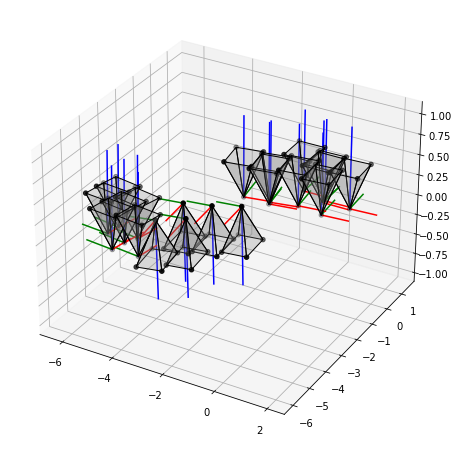

In [166]:
pts=naive_plot(points=False)

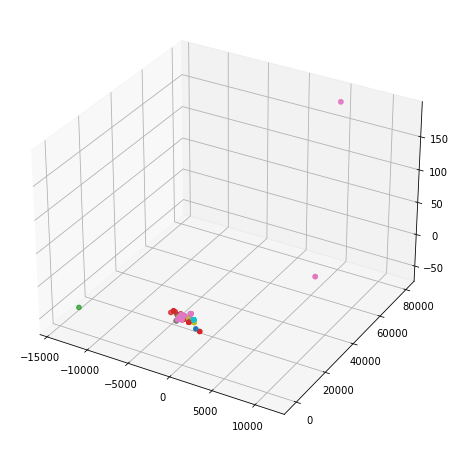

In [167]:
pts=naive_plot(cam_pose=False)

GTSAM

In [168]:
  
im_height, im_width = buddha[0].im.shape[:2]
    # get center point of image, this is our "pose"
camera_matrix = np.array([[1, 0, im_width/2], 
                        [0, 1, im_height/2],
                        [0, 0, 1]])

In [169]:
def get_non_max_suppression_mask(keypoints):
    binary_image = np.zeros((im_height, im_width))
    response_list = np.array([keypoint.response for keypoint in keypoints])
    mask = np.flip(np.argsort(response_list))
    point_list = np.rint([keypoint.pt for keypoint in keypoints])[
        mask].astype(int)
    non_max_suppression_mask = []
    for point, index in zip(point_list, mask):
        if binary_image[point[1], point[0]] == 0:
            non_max_suppression_mask.append(index)
            cv2.circle(binary_image, (point[0], point[1]), 3, 255, -1)

    return non_max_suppression_mask

In [170]:

keypoints_list = []
descriptors_list = []
object_index_list = []

for image in buddha:
    pt_tuple=siftDC(image.im)
    keypoints, descriptors = pt_tuple.k,pt_tuple.d
    non_max_suppression_mask = get_non_max_suppression_mask(keypoints)

    keypoints_list.append(np.array(keypoints)[non_max_suppression_mask])
    descriptors_list.append(np.array(descriptors)[non_max_suppression_mask])

    object_index_list.append(np.full(len(keypoints), -1, int))

In [171]:
def get_pose_index_mask(dst_points, src_points):
    essential_matrix, essential_mask = cv2.findEssentialMat(
        dst_points, src_points, camera_matrix, cv2.RANSAC, 0.999, 1.0)

    essential_mask = np.squeeze(essential_mask != 0)

    index_mask = np.arange(len(src_points))

    index_mask = index_mask[essential_mask]
    src_points = src_points[essential_mask]
    dst_points = dst_points[essential_mask]

    _, rotation_matrix, translation, pose_mask = cv2.recoverPose(
        essential_matrix, dst_points, src_points, camera_matrix)

    pose_mask = np.squeeze(pose_mask != 0)
    
    return rotation_matrix, translation, index_mask[pose_mask]

In [172]:
def plot_match_points(left_image, right_image, left_points, right_points):


    match_image = np.hstack((left_image, right_image))
    left_image_width = left_image.shape[1]
    for left_point, right_point in zip(left_points.astype(int), right_points.astype(int)):
        left_match_point = tuple(left_point)
        right_match_point = tuple(right_point + np.array([left_image_width, 0]))
        cv2.circle(match_image, left_match_point, 5, (0, 255, 0), -1)
        cv2.circle(match_image, right_match_point, 5, (0, 255, 0), -1)
        cv2.line(match_image, left_match_point, right_match_point, (0, 255, 0), 1)

    plt.imshow(match_image)
    plt.show()


def get_rint(num):
    return np.rint(num).astype(int)

In [173]:
bf_matcher = cv2.BFMatcher(cv2.NORM_L2)


def get_match_points(src_keypoints, src_descriptors, dst_keypoints, dst_descriptors):

    matches = bf_matcher.knnMatch(src_descriptors, dst_descriptors, k=2)

    cross_matches = bf_matcher.match(dst_descriptors, src_descriptors)

    cross_match_dict = {}
    for cross_match in cross_matches:
        cross_match_dict[cross_match.trainIdx] = cross_match.queryIdx

    src_points = []
    dst_points = []
    src_point_index_list = []
    dst_point_index_list = []

    for match_1, match_2 in matches:
#         if match_1.queryIdx in cross_match_dict and cross_match_dict[match_1.queryIdx] == match_1.trainIdx and match_1.distance < 0.75*match_2.distance:
        if match_1.distance < 0.75*match_2.distance:
            src_points.append(src_keypoints[match_1.queryIdx].pt)
            dst_points.append(dst_keypoints[match_1.trainIdx].pt)
            src_point_index_list.append(match_1.queryIdx)
            dst_point_index_list.append(match_1.trainIdx)

    return np.array(src_points), np.array(dst_points), np.array(src_point_index_list), np.array(dst_point_index_list)

In [174]:
symbol_X = gtsam.symbol_shorthand.X
symbol_L = gtsam.symbol_shorthand.L

gtsam_camera_matrix = gtsam.Cal3_S2(
    camera_matrix[0, 0], camera_matrix[1, 1], 0.0, camera_matrix[0, 2], camera_matrix[1, 2])

measurement_noise = gtsam.noiseModel.Isotropic.Sigma(2, 1.0)

pose_noise = gtsam.noiseModel.Diagonal.Sigmas(
    np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))

point_noise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)

graph = gtsam.NonlinearFactorGraph()

initial = gtsam.Values()

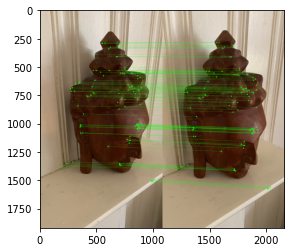

In [175]:
src_points, dst_points, src_point_index_list, dst_point_index_list = get_match_points(
    keypoints_list[0], descriptors_list[0], keypoints_list[1], descriptors_list[1])

rotation_matrix, translation, index_mask = get_pose_index_mask(
    dst_points, src_points)

src_points = src_points[index_mask]
dst_points = dst_points[index_mask]
src_point_index_list = src_point_index_list[index_mask]
dst_point_index_list = dst_point_index_list[index_mask]

plot_match_points(buddha[0].im, buddha[1].im, src_points, dst_points)

In [176]:
def get_object_points(src_projection_matrix, dst_projection_matrix, src_points, dst_points):
    
    object_points = cv2.triangulatePoints(
        src_projection_matrix, dst_projection_matrix, src_points.T, dst_points.T)

    return (object_points/object_points[-1])[:-1].T

In [177]:
def get_transformation_matrix(rotation_matrix, translation):
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :] = np.hstack((rotation_matrix, translation))
    return transformation_matrix

In [178]:
def get_projection_matrix(transformation_matrix):
    return camera_matrix.dot(np.linalg.inv(transformation_matrix)[:3])
#     return camera_matrix.dot(transformation_matrix[:3])

In [179]:
transformation_matrix = get_transformation_matrix(rotation_matrix, translation)

pose_factor = gtsam.PriorFactorPose3(symbol_X(0), gtsam.Pose3(), pose_noise)
graph.push_back(pose_factor)

initial.insert(symbol_X(0), gtsam.Pose3())

initial.insert(symbol_X(1),
               gtsam.Pose3(gtsam.Rot3(rotation_matrix),
                           gtsam.Point3(translation.flatten())))

projection_matrix = get_projection_matrix(transformation_matrix)

sum_all_object_points = list(get_object_points(
    camera_matrix.dot(np.hstack((np.eye(3), np.zeros((3, 1))))), projection_matrix, src_points, dst_points))

prev_transformation_matrix = transformation_matrix.copy()
prev_projection_matrix = projection_matrix.copy()

point_factor = gtsam.PriorFactorPoint3(
    symbol_L(0), sum_all_object_points[0], point_noise)
graph.push_back(point_factor)

sum_all_object_points_color = []
all_object_points_count = []

src_object_index_array = object_index_list[0]
dst_object_index_array = object_index_list[1]
src_bgr_image = buddha[0].im
dst_bgr_image = buddha[1].im

rint_src_points = get_rint(src_points)
rint_dst_points = get_rint(dst_points)

for object_index, (src_point, dst_point, src_point_index, dst_point_index, object_point, rint_src_point, rint_dst_point) in enumerate(zip(src_points,
                                                                                                                                          dst_points,
                                                                                                                                          src_point_index_list,
                                                                                                                                          dst_point_index_list,
                                                                                                                                          sum_all_object_points,
                                                                                                                                          rint_src_points,
                                                                                                                                          rint_dst_points)):

    src_object_index_array[src_point_index] = object_index
    dst_object_index_array[dst_point_index] = object_index

    graph.push_back(gtsam.GenericProjectionFactorCal3_S2(
        src_point, measurement_noise, symbol_X(0), symbol_L(object_index), gtsam_camera_matrix))

    graph.push_back(gtsam.GenericProjectionFactorCal3_S2(
        dst_point, measurement_noise, symbol_X(1), symbol_L(object_index), gtsam_camera_matrix))

    sum_all_object_points_color.append(
        src_bgr_image[rint_src_point[1], rint_src_point[0]]+dst_bgr_image[rint_dst_point[1], rint_dst_point[0]])

    all_object_points_count.append(2)

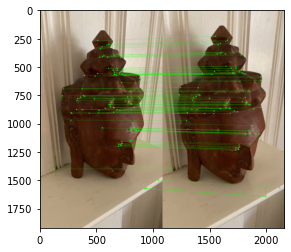

0.592417238488785
---


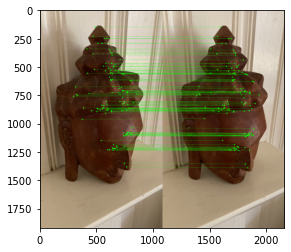

0.10065311539370697
---


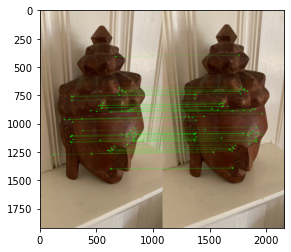

0.39399763287862566
---


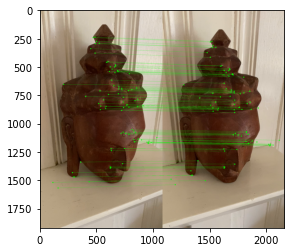

1.6415306442036748
---


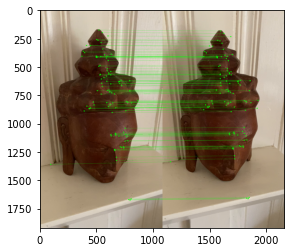

0.7398464830805014
---


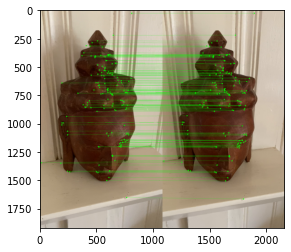

1.0983379216356144
---


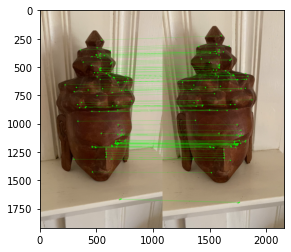

0.98074895955812
---


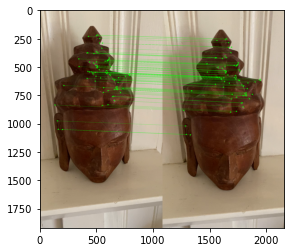

1.3707088015172302
---


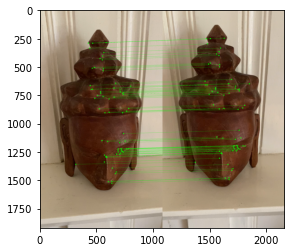

0.03466500633624928
---


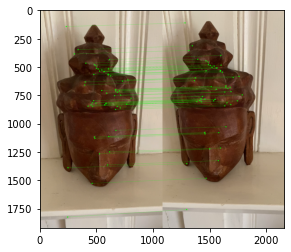

0.3323321734698805
---


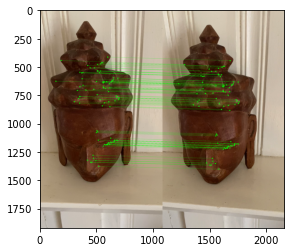

0.9209216113046135
---


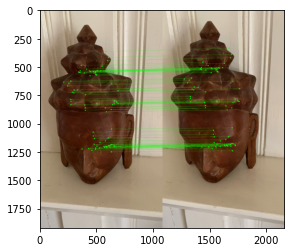

0.07961217773402449
---


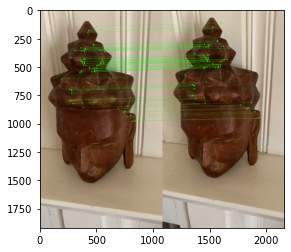

0.6707513743261239
---


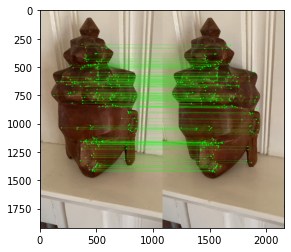

2.033958519031408
---


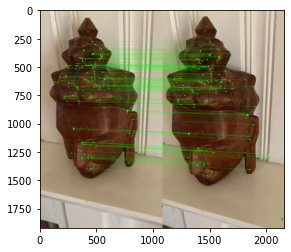

1.2521918820565836
---


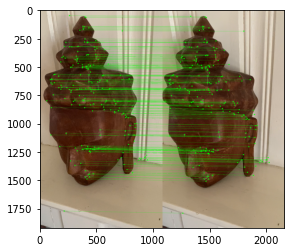

2.2656605961547416
---


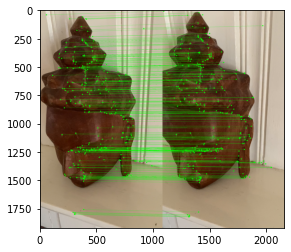

0.3831647235912505
---


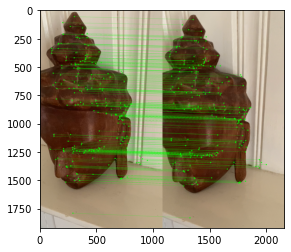

0.6450808692512002
---


In [180]:
for src_index in range(1, len(buddha)-1):

    dst_index = src_index+1

    src_points, dst_points, src_point_index_list, dst_point_index_list = get_match_points(
        keypoints_list[src_index], descriptors_list[src_index], keypoints_list[dst_index], descriptors_list[dst_index])

    rotation_matrix, translation, index_mask = get_pose_index_mask(
        dst_points, src_points)

    src_points = src_points[index_mask]
    dst_points = dst_points[index_mask]
    src_point_index_list = src_point_index_list[index_mask]
    dst_point_index_list = dst_point_index_list[index_mask]

    plot_match_points(
        buddha[src_index].im, buddha[dst_index].im, src_points, dst_points)

    transformation_matrix = get_transformation_matrix(
        rotation_matrix, translation).dot(prev_transformation_matrix)
#     transformation_matrix = prev_transformation_matrix.dot(
#         get_transformation_matrix(rotation_matrix, translation))
    projection_matrix = get_projection_matrix(transformation_matrix)

    match_src_points = []
    match_dst_points = []
    match_object_points = []

    src_object_index_array = object_index_list[src_index]
    dst_object_index_array = object_index_list[dst_index]
    src_bgr_image = buddha[src_index].im
    dst_bgr_image = buddha[dst_index].im

    for src_point, dst_point, src_point_index in zip(src_points, dst_points, src_point_index_list):

        object_index = src_object_index_array[src_point_index]
        if object_index != -1:
            match_src_points.append(src_point)
            match_dst_points.append(dst_point)
            match_object_points.append(
                sum_all_object_points[object_index]/(all_object_points_count[object_index]-1))

    match_src_points = np.array(match_src_points)
    match_dst_points = np.array(match_dst_points)
    match_object_points = np.array(match_object_points)

    object_points = get_object_points(
        prev_projection_matrix, projection_matrix, match_src_points, match_dst_points)

#     test_scale=0
#     test_count = 0
#     for pair_index_1, pair_index_2 in itertools.combinations(range(len(object_points)), 2):
#         test_scale += cv2.norm(match_object_points[pair_index_1]-match_object_points[pair_index_2])/cv2.norm(
#             object_points[pair_index_1]-object_points[pair_index_2])
#         test_count += 1
#     print(test_scale/test_count)

    scale = 0
    for match_object_point, object_point in zip(match_object_points, object_points):
        scale += cv2.norm(match_object_point)/cv2.norm(object_point)

    scale /= len(object_points)
    print(scale)
    print('---')

#     scale = 1

#     print(translation)

    translation *= scale

    transformation_matrix = get_transformation_matrix(
        rotation_matrix, translation).dot(prev_transformation_matrix)
#     transformation_matrix = prev_transformation_matrix.dot(
#         get_transformation_matrix(rotation_matrix, translation))

#     print(transformation_matrix[2, 3])

    initial.insert(symbol_X(dst_index),
                   gtsam.Pose3(gtsam.Rot3(transformation_matrix[:3, :3]),
                               gtsam.Point3(transformation_matrix[:3, 3])))

    projection_matrix = get_projection_matrix(transformation_matrix)

    object_points = get_object_points(
        prev_projection_matrix, projection_matrix, src_points, dst_points)

    prev_transformation_matrix = transformation_matrix.copy()
    prev_projection_matrix = projection_matrix.copy()

    rint_src_points = get_rint(src_points)
    rint_dst_points = get_rint(dst_points)

    current_object_index = len(all_object_points_count)

    for src_point, dst_point, src_point_index, dst_point_index, object_point, rint_src_point, rint_dst_point in zip(src_points,
                                                                                                                    dst_points,
                                                                                                                    src_point_index_list,
                                                                                                                    dst_point_index_list,
                                                                                                                    object_points,
                                                                                                                    rint_src_points,
                                                                                                                    rint_dst_points):
        object_index = src_object_index_array[src_point_index]
        if object_index == -1:

            object_index = current_object_index

            sum_all_object_points.append(object_point)
            sum_all_object_points_color.append(
                src_bgr_image[rint_src_point[1], rint_src_point[0]] + dst_bgr_image[rint_dst_point[1], rint_dst_point[0]])
            all_object_points_count.append(2)

            src_object_index_array[src_point_index] = dst_object_index_array[
                dst_point_index] = object_index

            current_object_index += 1
        else:
            dst_object_index_array[dst_point_index] = object_index

            sum_all_object_points[object_index] += object_point
            sum_all_object_points_color[object_index] += dst_bgr_image[rint_dst_point[1],
                                                                       rint_dst_point[0]]
            all_object_points_count[object_index] += 1

        graph.push_back(gtsam.GenericProjectionFactorCal3_S2(
            src_point, measurement_noise, symbol_X(src_index), symbol_L(object_index), gtsam_camera_matrix))

        graph.push_back(gtsam.GenericProjectionFactorCal3_S2(
            dst_point, measurement_noise, symbol_X(dst_index), symbol_L(object_index), gtsam_camera_matrix))

In [181]:
all_object_points_count = np.array(
    [all_object_points_count, all_object_points_count, all_object_points_count]).T

all_object_points = np.array(sum_all_object_points)/(all_object_points_count-1)
all_object_points_color = np.flip(np.array(
    sum_all_object_points_color)/all_object_points_count).astype(np.uint8)

for object_index, object_point in enumerate(all_object_points):
    initial.insert(symbol_L(object_index),
                   gtsam.Point3(object_point))

params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
result = optimizer.optimize()

print(result)

Values with 1761 values:
Value l0: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	0.0301394;
	-8.61783;
	0.0248748
]

Value l1: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	0.0929753;
	-7.99176;
	0.0237969
]

Value l2: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	3.88348;
	-4.29529;
	0.0220287
]

Value l3: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	1.78077;
	-7.65629;
	0.023405
]

Value l4: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	1.7036;
	-1.65175;
	0.0195546
]

Value l5: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	2.85404;
	-5.37;
	0.0231341
]

Value l6: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	2.5609;
	-2.88282;
	0.0202302
]

Value l7: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-6.13901;
	7.70888;
	0.0287611
]

Value l8: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	3.59963;
	0.934239;
	0.0202202
]

Value l9: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	1.39588;
	-5.81999;
	0.0216255
]

Value l10: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-2.98564;
	-4.95865;
	0.0273421
]

Value l

/tmp/ipykernel_35430/1954060161.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
/home/jordan/anaconda3/lib/python3.9/site-packages/gtsam/utils/plot.py:380: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axes = fig.gca(projection='3d')
/home/jordan/anaconda3/lib/python3.9/site-

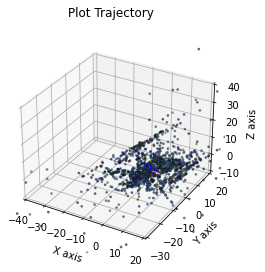

In [184]:

fig = plt.figure()
ax = fig.gca(projection='3d')

final_object_points = []
for index in range(len(all_object_points)):
    final_object_points.append(result.atPoint3(symbol_L(index)))

final_object_points = np.array(final_object_points)

ax.scatter(final_object_points[:, 0],
           final_object_points[:, 1], final_object_points[:, 2], c=all_object_points_color/255., s=3)

# gtsam.utils.plot.plot_3d_points(1, result)
gtsam.utils.plot.plot_trajectory(1, result, scale=2)
gtsam.utils.plot.set_axes_equal(1)

ax.set_xlim3d(-40, 20)
ax.set_ylim3d(-30, 20)
ax.set_zlim3d(-10, 40)


plt.show()